# Chapter 5: 機械学習 実践編

機械学習のアルゴリズムをまとめたモジュール[scikit-learn](http://scikit-learn.org/stable/)を学ぶ．  
簡単なアルゴリズムを用いた実験と評価について，コードを読みつつ知る．

1. scikit-learnについて
    1. モジュールの概要
    2. データセットのダウンロードと実験
    3. モデルの評価
2. 問題に合わせたコーディング
    1. Irisの可視化
    2. テキストデータの処理
        1. Pipelineの作成

## 5-1. scikit-learnについて
### 5-1-1. モジュールの概要
[scikit-learn](http://scikit-learn.org/stable/)のホームページに詳しい情報がある． 

#### 特徴
- scikit-learn(sklearn)には，多くの機械学習アルゴリズムが入っており，統一した形式で書かれているため利用しやすい．
- 各手法をコードで理解するだけでなく，その元となる論文も紹介されている．
- チュートリアルやどのように利用するのかをまとめたページもあり，似た手法が列挙されている．


### 5-1-2. データセットのダウンロードと実験

例題としてIrisデータセットを用いる．  
Irisはアヤメのデータであり，3種類の花があり，花の大きさなどの4つの特徴が与えられている．  
花の大きさなどの4つの特徴から，どの花なのかを予測する問題を解いてみよう．

#### 実験手順
0. データセットを用意する
1. データを学習用，テスト用に分割する
2. 学習用データを用いて，分類器を学習させる
3. テスト用データを用いて，分類器の性能を測る

In [4]:
# 1. データセットを用意する
from sklearn import datasets
iris = datasets.load_iris() # ここではIrisデータセットを読み込む
print(iris.data[0], iris.target[0]) # 1番目のサンプルのデータとラベル

[ 5.1  3.5  1.4  0.2] 0


In [46]:
# 2.学習用データとテスト用データに分割する
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)

# 3. 線形SVMという手法を用いて分類する
from sklearn.svm import SVC, LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train) # 学習

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [47]:
# 4. 分類器の性能を測る
y_pred = clf.predict(X_test) # 予測

from sklearn import metrics
print(metrics.classification_report(y_true=y_test, y_pred=y_pred)) # 予測結果の評価

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        15
          1       0.83      0.91      0.87        11
          2       0.91      0.83      0.87        12

avg / total       0.92      0.92      0.92        38



### 5-1-3. モデルの評価
性能を測るといっても，その目的によって指標を変える必要がある. 
どのような問題で，どのような指標を用いることが一般的か？という問いに対しては，先行研究を確認することを勧める．
また，指標それぞれの特性(数学的な意味)を知っていることもその役に立つだろう．
[参考文献:scikit-learn Model Evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)

例えば，今回の分類問題に対する指標について考えてみよう．一般的な指標だけでも以下の4つがある．
1. 正解率(accuracy)
2. 精度(precision)
3. 再現率(recall)
4. F値(F1-score)

（精度，再現率，F値にはmacro, micro, weightedなどがある）

今回の実験でのそれぞれの値を見てみよう．

In [48]:
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision:', metrics.precision_score(y_test, y_pred, average='macro'))
print('recall:   ', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1 score: ', metrics.f1_score(y_test, y_pred, average='macro'))

accuracy:  0.921052631579
precision: 0.914141414141
recall:    0.914141414141
F1 score:  0.913043478261


## 5-2. 問題に合わせたコーディング

### 5-2-1. Irisデータの可視化
Irisデータは4次元だったので，直接可視化することはできない．  
4次元のデータをPCAによって圧縮して，2次元にし可視化する．

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X, y = iris.data, iris.target
X_pca = pca.fit_transform(X) # 次元圧縮
print(X_pca.shape)

(150, 2)


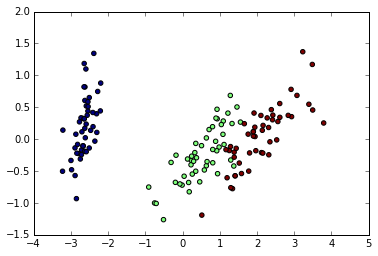

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y);

In [53]:
from sklearn.svm import SVC
# 次元圧縮したデータを用いて分類してみる
X_train, X_test, y_train, y_test = train_test_split(X_pca, iris.target)
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)

In [54]:
from sklearn import metrics
print(metrics.classification_report(y_true=y_test, y_pred=y_pred2)) # 予測結果の評価

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       0.83      1.00      0.91        10
          2       1.00      0.88      0.94        17

avg / total       0.96      0.95      0.95        38



### 5-2-2. テキストに対する処理

#### テキストから特徴量を設計
テキストのカウントベクトルを作成し，TF-IDFを用いて特徴ベクトルを作る．  
いくつかの設計ができるが，例題としてこの手法を用いる．

ここでは，20newsgroupsというデータセットを利用する．

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

news_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(news_train.data)

In [6]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#### Naive Bayseによる学習

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, news_train.target)

In [10]:
docs = ["God is love.", "I study about Computer Science."]
X_test_counts = count_vec.transform(docs)
X_test_tf = tf_transformer.transform(X_test_counts)
preds = clf.predict(X_test_tf)
for d, label_id in zip(docs, preds):
    print("{} -> {}".format(d, news_train.target_names[label_id]))

God is love. -> soc.religion.christian
I study about Computer Science. -> sci.med


このように文に対して，categoriesのうちのどれに対応するかを出力する学習器を作ることができた．  
この技術を応用することで，ある文がポジティブかネガティブか，スパムか否かなど自然言語の文に対する分類問題を解くことができる．  

### Pipelineによる結合

In [11]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('countvec', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

text_clf.fit(news_train.data, news_train.target)

Pipeline(steps=[('countvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [13]:
for d, label_id in zip(docs, text_clf.predict(docs)):
    print("{} -> {}".format(d, news_train.target_names[label_id]))

God is love. -> soc.religion.christian
I study about Computer Science. -> sci.med


## [練習問題](./../exercise/question5.md)